In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor



import joblib
sns.set(style='whitegrid')

print("Libraries imported.")


Libraries imported.


In [31]:
df = pd.read_csv("dataProductivity Prediction of Garment Employeese.csv")
print("✅ Dataset loaded successfully.")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded successfully.
Shape: (1302, 15)


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8.0,0.80,26.16,1108.0,7080.0,98.0,0.0,NaN,0.0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1.0,0.75,3.94,NaN,960.0,0.0,0.0,0.0,0.0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11.0,0.80,11.41,968.0,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12.0,0.80,11.41,NaN,3660.0,50.0,0.0,0.0,0.0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6.0,NaN,25.90,1170.0,1920.0,50.0,0.0,0.0,0.0,56.0,0.800382


In [32]:
# — Explore data structure

print("*** Dataset Info *** :")
print(df.info())

print("\n*** Missing Values per Column ***:")
print(df.isnull().sum())

print("\n *** Summary Statistics (numeric columns) *** :")
display(df.describe())

print("\n *** Unique values in some key categorical columns ***:")
for col in ['day', 'department', 'quarter']:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")


*** Dataset Info *** :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1272 non-null   object 
 1   quarter                1279 non-null   object 
 2   department             1275 non-null   object 
 3   day                    1274 non-null   object 
 4   team                   1278 non-null   float64
 5   targeted_productivity  1279 non-null   float64
 6   smv                    1276 non-null   float64
 7   wip                    729 non-null    float64
 8   over_time              1276 non-null   float64
 9   incentive              1275 non-null   float64
 10  idle_time              1275 non-null   float64
 11  idle_men               1278 non-null   float64
 12  no_of_style_change     1279 non-null   float64
 13  no_of_workers          1280 non-null   float64
 14  actual_productivity    1267 non-n

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1278.000000,1279.000000,1276.000000,729.000000,1276.000000,1275.000000,1275.000000,1278.000000,1279.000000,1280.000000,1267.000000
mean,6.443662,0.730274,15.061418,1148.422497,4551.332288,36.967843,0.688235,0.357590,0.146990,34.553906,0.734889
std,3.468331,0.096727,10.989957,1596.736245,3347.164546,155.419707,12.316019,3.191313,0.422717,22.256752,0.173802
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,762.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650173
50%,7.000000,0.750000,15.260000,1040.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.763375
75%,9.000000,0.800000,24.260000,1255.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850354
max,12.000000,0.800000,54.560000,21540.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437



 *** Unique values in some key categorical columns ***:
day: ['Thursday' nan 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']
department: ['sweing' 'finishing ' 'finishing' nan]
quarter: ['Quarter1' nan 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']


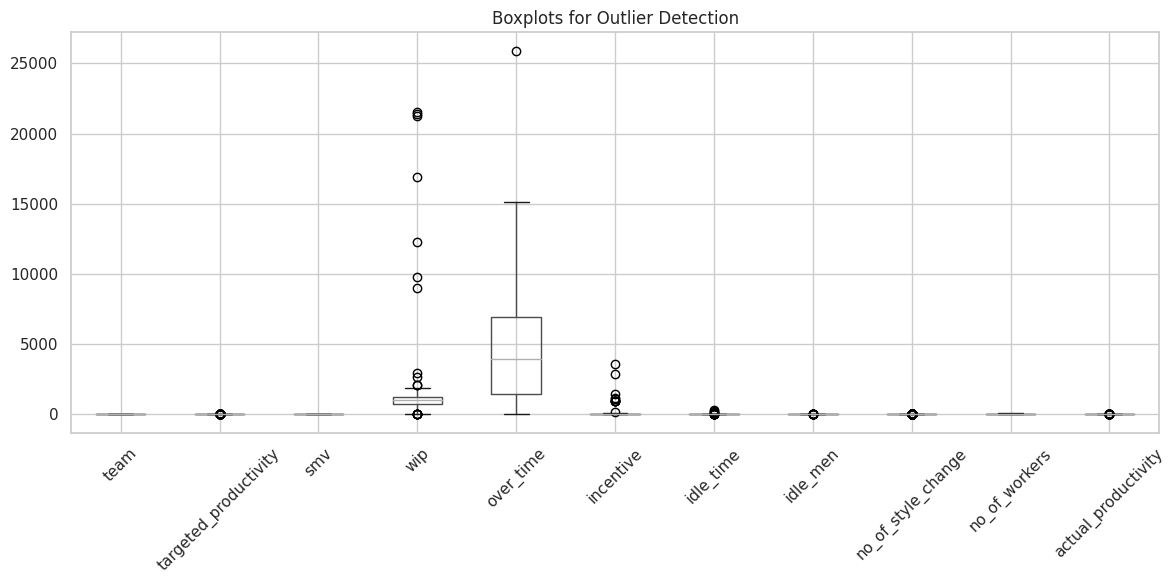

In [33]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64'])


plt.figure(figsize=(12, 6))
numeric_cols.boxplot()
plt.xticks(rotation=45)
plt.title("Boxplots for Outlier Detection")
plt.tight_layout()
plt.show()


In [34]:

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Dictionary to store outliers for each column
outliers_dict = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

    # Store in dictionary
    outliers_dict[col] = outliers

    # Print summary
    print(f"➡ {col}: {len(outliers)} outliers, lower_bound={lower_bound}, upper_bound={upper_bound}")



# Remove rows where 'over_time' is outside the bounds
df = df[(df['over_time'] >= -6840.0) & (df['over_time'] <= 15240.0)]
print("outlier removed")

➡ team: 0 outliers, lower_bound=-6.0, upper_bound=18.0
➡ targeted_productivity: 82 outliers, lower_bound=0.5499999999999998, upper_bound=0.9500000000000002
➡ smv: 0 outliers, lower_bound=-26.54, upper_bound=54.74
➡ wip: 17 outliers, lower_bound=22.5, upper_bound=1994.5
➡ over_time: 1 outliers, lower_bound=-6840.0, upper_bound=15240.0
➡ incentive: 11 outliers, lower_bound=-75.0, upper_bound=125.0
➡ idle_time: 19 outliers, lower_bound=0.0, upper_bound=0.0
➡ idle_men: 19 outliers, lower_bound=0.0, upper_bound=0.0
➡ no_of_style_change: 154 outliers, lower_bound=0.0, upper_bound=0.0
➡ no_of_workers: 0 outliers, lower_bound=-63.0, upper_bound=129.0
➡ actual_productivity: 44 outliers, lower_bound=0.34990309974999984, upper_bound=1.1506239017500002
outlier removed


In [35]:
# Strip whitespace in string columns
for col in ['department', 'quarter', 'day']:
    df[col] = df[col].astype(str).str.strip()

# Fix unexpected values in 'quarter'
df['quarter'] = df['quarter'].replace({'Quarter5': 'Quarter4'})

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Impute missing values
# Numeric columns (except 'wip' for now)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('wip')  # handle separately
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

# Categorical columns
cat_cols = ['day', 'department', 'quarter']
for col in cat_cols:
    df[col] = df[col].replace('nan', np.nan)
    df[col] = df[col].fillna(df[col].mode()[0])

# Impute 'wip' with median (less sensitive to outliers)
df['wip'] = df['wip'].fillna(df['wip'].median())

# Drop rows with missing 'actual_productivity' (target)
df = df.dropna(subset=['actual_productivity'])

print("✅ Data cleaned. New shape:", df.shape)
df.head()


✅ Data cleaned. New shape: (1275, 15)


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8.0,0.800000,26.16,1108.0,7080.0,98.0,0.0,0.335731,0.0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1.0,0.750000,3.94,1039.5,960.0,0.0,0.0,0.000000,0.0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11.0,0.800000,11.41,968.0,3660.0,50.0,0.0,0.000000,0.0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12.0,0.800000,11.41,1039.5,3660.0,50.0,0.0,0.000000,0.0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6.0,0.730607,25.90,1170.0,1920.0,50.0,0.0,0.000000,0.0,56.0,0.800382


In [36]:
# — Feature engineering

# Per-worker features
df['wip_per_worker'] = df['wip'] / df['no_of_workers']
df['over_time_per_worker'] = df['over_time'] / df['no_of_workers']
df['idle_time_per_worker'] = df['idle_time'] / df['idle_men'].replace(0,1)  # avoid division by zero

# Target variable
target = 'actual_productivity'

# Feature columns
X_cols = df.drop(columns=[target, 'date']).columns.tolist()

print("✅ Feature engineering done. Example of new features:")
display(df[['wip_per_worker', 'over_time_per_worker', 'idle_time_per_worker']].head())


✅ Feature engineering done. Example of new features:


,wip_per_worker,over_time_per_worker,idle_time_per_worker
0,18.779661,120.000000,0.0
1,129.937500,120.000000,0.0
2,31.737705,120.000000,0.0
3,34.081967,120.000000,0.0
4,20.892857,34.285714,0.0


In [37]:
# — Preprocessing + Train/Test split


categorical_cols = ['day', 'department', 'quarter']
numeric_cols = [col for col in X_cols if col not in categorical_cols]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)


X = df[X_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Preprocessing + Train/Test split done.")
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


✅ Preprocessing + Train/Test split done.
Train shape: (1020, 16) (1020,)
Test shape: (255, 16) (255,)


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ('pre', preprocessor),  # your preprocessing steps
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])


In [39]:
# Add features (keep full dataset)
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

# Interaction
X_train_fe['wip_x_workers'] = X_train_fe['wip'] * X_train_fe['no_of_workers']
X_test_fe['wip_x_workers'] = X_test_fe['wip'] * X_test_fe['no_of_workers']

# Ratios
X_train_fe['incentive_per_worker'] = X_train_fe['incentive'] / (X_train_fe['no_of_workers'] + 1e-6)
X_test_fe['incentive_per_worker'] = X_test_fe['incentive'] / (X_test_fe['no_of_workers'] + 1e-6)

X_train_fe['wip_per_worker'] = X_train_fe['wip'] / (X_train_fe['no_of_workers'] + 1e-6)
X_test_fe['wip_per_worker'] = X_test_fe['wip'] / (X_test_fe['no_of_workers'] + 1e-6)

# Optional productivity ratio
X_train_fe['target_prod_ratio'] = X_train_fe['targeted_productivity'] / (y_train + 1e-6)
X_test_fe['target_prod_ratio'] = X_test_fe['targeted_productivity'] / (y_test + 1e-6)

# Re-fit Random Forest
rf_pipeline.fit(X_train_fe, y_train)
y_pred_rf_fe = rf_pipeline.predict(X_test_fe)

# Metrics
rmse_rf_fe = np.sqrt(mean_squared_error(y_test, y_pred_rf_fe))
mae_rf_fe = mean_absolute_error(y_test, y_pred_rf_fe)
r2_rf_fe = r2_score(y_test, y_pred_rf_fe)

print("Random Forest Metrics after Feature Engineering:")
print(f"RMSE: {rmse_rf_fe:.4f}, MAE: {mae_rf_fe:.4f}, R²: {r2_rf_fe:.4f}")


Random Forest Metrics after Feature Engineering:
RMSE: 0.1252, MAE: 0.0787, R²: 0.5121


In [22]:
# Linear Regression pipeline
lr_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# Metrics
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Metrics:")
print(f"RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R²: {r2_lr:.4f}\n")

# Random Forest pipeline
rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Metrics:")
print(f"RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R²: {r2_rf:.4f}")

# AdaBoost Pipeline
ada_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', AdaBoostRegressor(
        n_estimators=100,
        random_state=42,
        learning_rate=1.0
    ))
])

# Train the model
ada_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_ada = ada_pipeline.predict(X_test)

# Calculate metrics
rmse_ada = np.sqrt(mean_squared_error(y_test, y_pred_ada))
mae_ada = mean_absolute_error(y_test, y_pred_ada)
r2_ada = r2_score(y_test, y_pred_ada)

print("AdaBoost Regression Metrics:")
print(f"RMSE: {rmse_ada:.4f}")
print(f"MAE: {mae_ada:.4f}")
print(f"R²: {r2_ada:.4f}")


#decision tree
dt_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])
# Train the model
dt_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_pipeline.predict(X_test)

# Calculate metrics
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Regression Metrics:")
print(f"RMSE: {rmse_dt:.4f}")
print(f"MAE: {mae_dt:.4f}")
print(f"R²: {r2_dt:.4f}")


# KNN Regression pipeline
knn_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=5))
])

# Train the model
knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_pipeline.predict(X_test)

# Calculate metrics
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("KNN Regression Metrics:")
print(f"RMSE: {rmse_knn:.4f}")
print(f"MAE: {mae_knn:.4f}")
print(f"R²: {r2_knn:.4f}")


Linear Regression Metrics:
RMSE: 0.1648, MAE: 0.1185, R²: 0.1546

Random Forest Regression Metrics:
RMSE: 0.1252, MAE: 0.0787, R²: 0.5121
AdaBoost Regression Metrics:
RMSE: 0.1448
MAE: 0.1075
R²: 0.3472
Decision Tree Regression Metrics:
RMSE: 0.1722
MAE: 0.0957
R²: 0.0768
KNN Regression Metrics:
RMSE: 0.1510
MAE: 0.1041
R²: 0.2902


In [40]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Step 1: Cross-validation check for Random Forest pipeline
scores = cross_val_score(
    rf_pipeline,        # use your pipeline (includes preprocessing + model)
    X, y,               # full dataset
    cv=5,               # 5-fold CV
    scoring='r2'        # R² metric
)

print("Cross-Validation R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Std of R²:", np.std(scores))


Cross-Validation R² scores: [0.3955587  0.47362503 0.44997713 0.17198069 0.55224085]
Mean R²: 0.40867647871572343
Std of R²: 0.12863262076829537


In [41]:
# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Linear Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'Decision Tree': y_pred_dt,
    'K-Nearest Neighbors': y_pred_knn,
    'AdaBoost': y_pred_ada
})

# Display first 10 predictions
print("First 10 Predictions Comparison:")
print(comparison_df.head(10))

# Display summary statistics
print("\nPrediction Statistics:")
print(comparison_df.describe())

First 10 Predictions Comparison:
        Actual  Linear Regression  Random Forest  Decision Tree  \
1206  0.600598           0.624644       0.615767       0.600598   
352   0.978526           0.775046       0.814554       0.670216   
667   0.750028           0.746686       0.746051       0.750396   
791   0.800312           0.737001       0.799407       0.800402   
823   0.991800           0.752543       0.892425       0.885926   
368   0.505128           0.710237       0.731440       0.860653   
44    0.861679           0.779464       0.866976       0.925644   
235   0.526810           0.751375       0.533711       0.526810   
633   0.522845           0.241446       0.411918       0.350302   
43    0.879714           0.798020       0.771866       0.734857   

      K-Nearest Neighbors  AdaBoost  
1206             0.657852  0.583771  
352              0.854290  0.781724  
667              0.800296  0.776868  
791              0.800328  0.770619  
823              0.788424  0.781724  
3

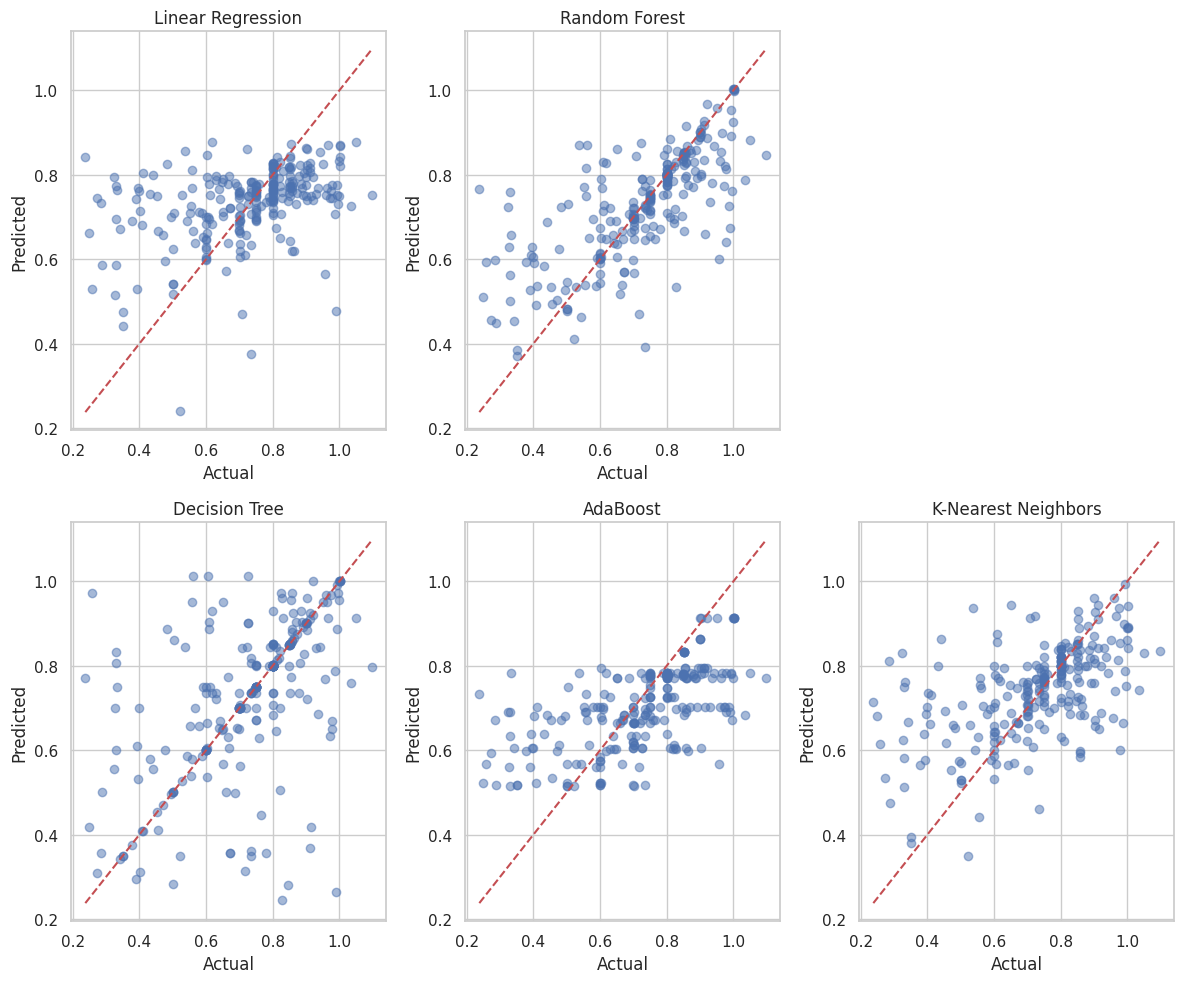

In [42]:
# Plot actual vs predicted for each model
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Linear Regression
axes[0,0].scatter(y_test, y_pred_lr, alpha=0.5)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,0].set_title('Linear Regression')
axes[0,0].set_xlabel('Actual')
axes[0,0].set_ylabel('Predicted')

# Random Forest
axes[0,1].scatter(y_test, y_pred_rf, alpha=0.5)
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,1].set_title('Random Forest')
axes[0,1].set_xlabel('Actual')
axes[0,1].set_ylabel('Predicted')

# Decision Tree
axes[1,0].scatter(y_test, y_pred_dt, alpha=0.5)
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1,0].set_title('Decision Tree')
axes[1,0].set_xlabel('Actual')
axes[1,0].set_ylabel('Predicted')

# AdaBoost
axes[1,1].scatter(y_test, y_pred_ada, alpha=0.5)
axes[1,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1,1].set_title('AdaBoost')
axes[1,1].set_xlabel('Actual')
axes[1,1].set_ylabel('Predicted')


# K-Nearest Neighbors
axes[1,2].scatter(y_test, y_pred_knn, alpha=0.5)
axes[1,2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1,2].set_title('K-Nearest Neighbors')
axes[1,2].set_xlabel('Actual')
axes[1,2].set_ylabel('Predicted')

# Hide the unused subplot (top right: axes[0,2])
axes[0,2].axis('off')


plt.tight_layout()
plt.show()

In [43]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Hyperparameter space (no 'auto', only valid options)
param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(3, 20),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5),
    'model__max_features': ['sqrt', 'log2', None]
}

# Randomized search
rf_random = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42,
    error_score='raise'  # Raises error for invalid hyperparameters
)

rf_random.fit(X_train, y_train)
print("✅ Best hyperparameters found:")
print(rf_random.best_params_)

# Evaluate tuned model
y_pred_rf_tuned = rf_random.predict(X_test)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print("\nTuned Random Forest Metrics:")
print(f"RMSE: {rmse_rf_tuned:.4f}, MAE: {mae_rf_tuned:.4f}, R²: {r2_rf_tuned:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best hyperparameters found:
{'model__max_depth': 16, 'model__max_features': 'log2', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 445}

Tuned Random Forest Metrics:
RMSE: 0.1272, MAE: 0.0839, R²: 0.4964


✅ Top 10 important features:


,feature,importance
1,targeted_productivity,0.194493
5,incentive,0.132952
2,smv,0.096629
0,team,0.092945
10,wip_per_worker,0.085090
4,over_time,0.075847
9,no_of_workers,0.075743
11,over_time_per_worker,0.047640
3,wip,0.041842
8,no_of_style_change,0.020168


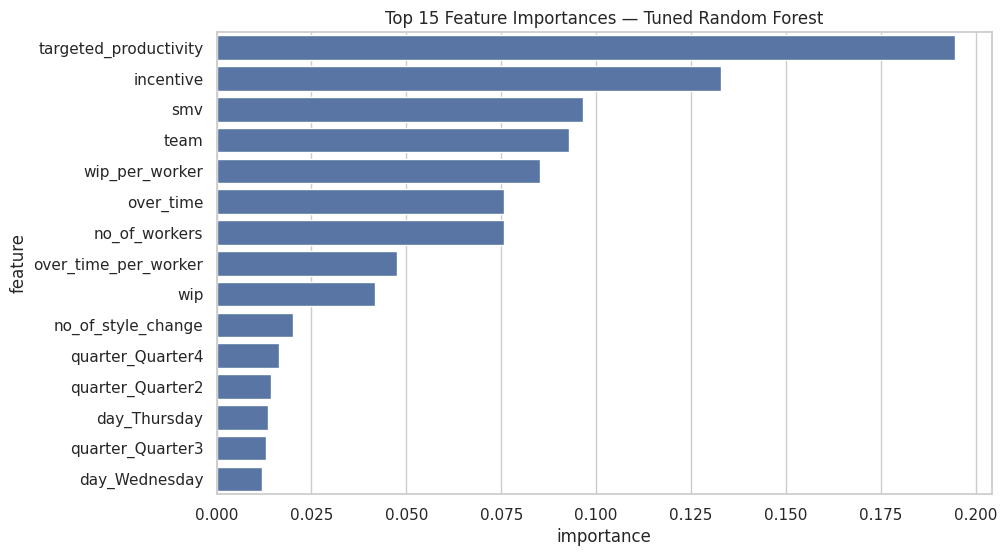

In [46]:
# Cell 9 — Feature importance

importances = rf_random.best_estimator_.named_steps['model'].feature_importances_
feature_names = rf_random.best_estimator_.named_steps['pre'].transformers_[0][2] + \
                list(rf_random.best_estimator_.named_steps['pre'].transformers_[1][1].get_feature_names_out())

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

print("✅ Top 10 important features:")
display(feat_imp.head(10))

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp.head(15))
plt.title("Top 15 Feature Importances — Tuned Random Forest")
plt.show()



In [47]:
# — Save the model
import joblib

# Save the tuned Random Forest pipeline
joblib.dump(rf_random.best_estimator_, 'tuned_rf_productivity_model.pkl')
print(" Tuned Random Forest model saved as 'tuned_rf_productivity_model.pkl'")


 Tuned Random Forest model saved as 'tuned_rf_productivity_model.pkl'


In [48]:
#— Load and test the saved model
import joblib

# Load model
model = joblib.load('tuned_rf_productivity_model.pkl')
print(" Model loaded successfully.")

# Predict on test set
y_pred = model.predict(X_test)

# Compare predictions with actual
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display(comparison.head(10))  # first 10 rows

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


 Model loaded successfully.


,Actual,Predicted
1206,0.600598,0.613063
352,0.978526,0.800356
667,0.750028,0.756447
791,0.800312,0.777659
823,0.991800,0.865358
368,0.505128,0.704011
44,0.861679,0.841891
235,0.526810,0.558456
633,0.522845,0.495157
43,0.879714,0.764627



Test Set Metrics:
RMSE: 0.1272
MAE: 0.0839
R²: 0.4964


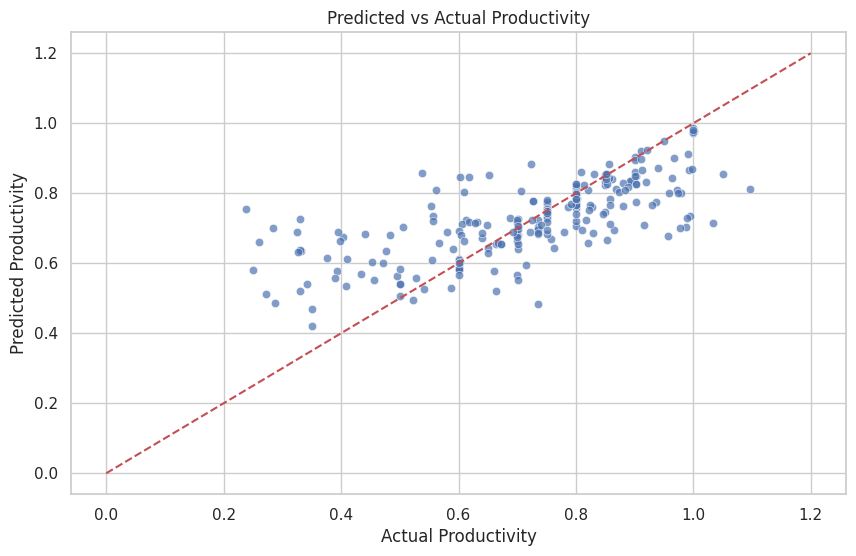

In [49]:
# Dashboard 1 — Predicted vs Actual
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([0, 1.2], [0, 1.2], 'r--')  # Perfect prediction line
plt.xlabel("Actual Productivity")
plt.ylabel("Predicted Productivity")
plt.title("Predicted vs Actual Productivity")
plt.show()


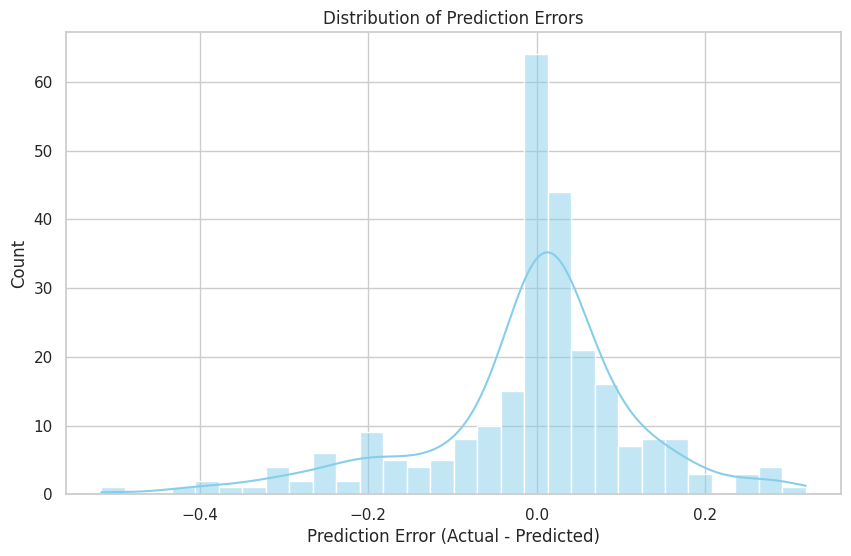

In [50]:
# Dashboard 2 — Error distribution
errors = y_test - y_pred
plt.figure(figsize=(10,6))
sns.histplot(errors, bins=30, kde=True, color='skyblue')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.title("Distribution of Prediction Errors")
plt.show()


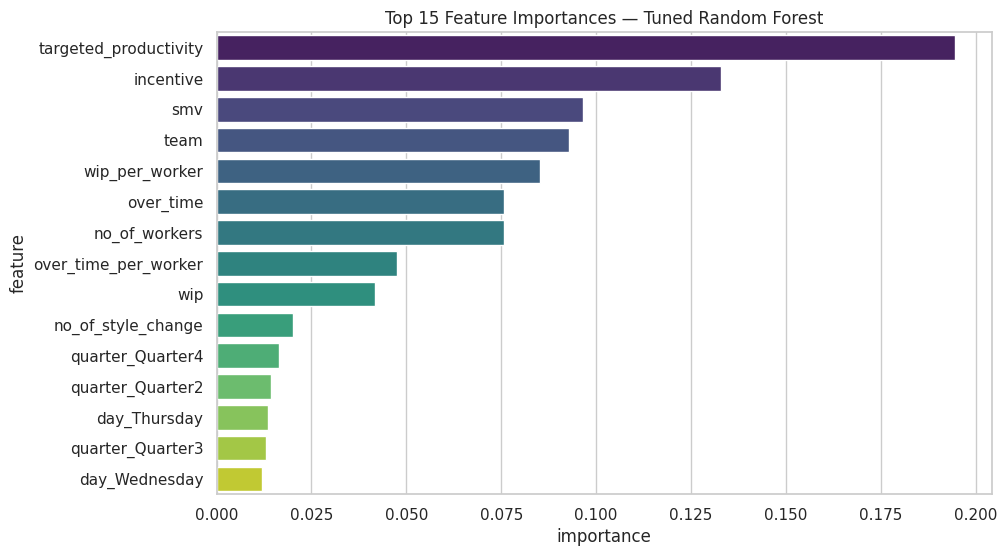

In [54]:
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp.head(15), hue='feature', palette='viridis', legend=False)
plt.title("Top 15 Feature Importances — Tuned Random Forest")
plt.show()


In [55]:
# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])

# Add predicted productivity column to the dataframe
df['predicted_productivity'] = model.predict(df[X_cols])

# Example: keep relevant columns for dashboards
df_dash = df[['date', 'department', 'team', 'actual_productivity', 'predicted_productivity']]


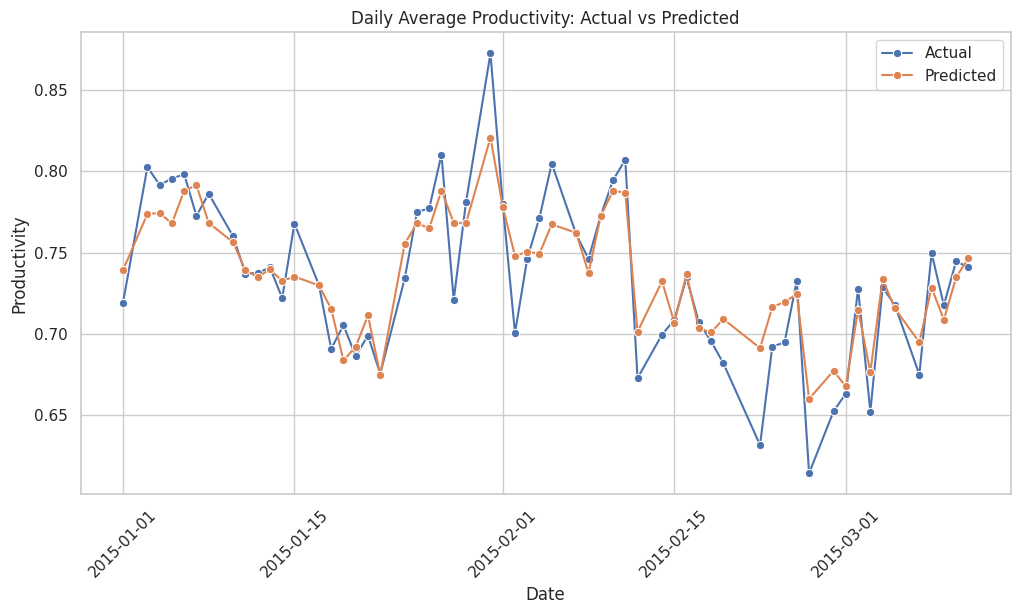

In [56]:
# Dashboard 4 — Time-series of actual vs predicted productivity
daily_prod = df_dash.groupby('date')[['actual_productivity','predicted_productivity']].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=daily_prod, x='date', y='actual_productivity', label='Actual', marker='o')
sns.lineplot(data=daily_prod, x='date', y='predicted_productivity', label='Predicted', marker='o')
plt.title("Daily Average Productivity: Actual vs Predicted")
plt.ylabel("Productivity")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()
plt.show()


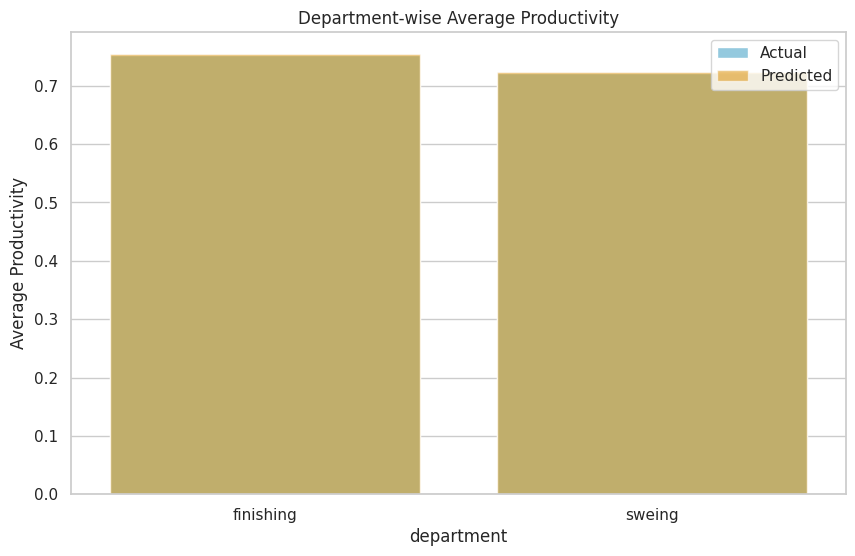

In [57]:
# Dashboard 5 — Department-wise comparison
dept_prod = df_dash.groupby('department')[['actual_productivity','predicted_productivity']].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='department', y='actual_productivity', data=dept_prod, color='skyblue', label='Actual')
sns.barplot(x='department', y='predicted_productivity', data=dept_prod, color='orange', alpha=0.6, label='Predicted')
plt.title("Department-wise Average Productivity")
plt.ylabel("Average Productivity")
plt.legend()
plt.show()


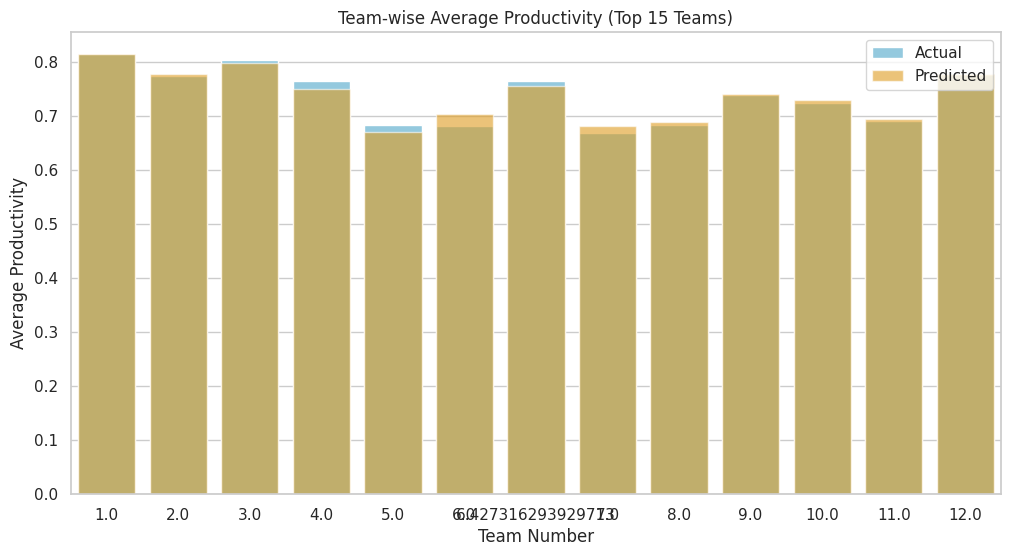

In [58]:
# Dashboard 6 — Team-wise comparison (top 15 teams by number of entries)
top_teams = df_dash['team'].value_counts().head(15).index
team_prod = df_dash[df_dash['team'].isin(top_teams)]
team_avg = team_prod.groupby('team')[['actual_productivity','predicted_productivity']].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='team', y='actual_productivity', data=team_avg, color='skyblue', label='Actual')
sns.barplot(x='team', y='predicted_productivity', data=team_avg, color='orange', alpha=0.6, label='Predicted')
plt.title("Team-wise Average Productivity (Top 15 Teams)")
plt.ylabel("Average Productivity")
plt.xlabel("Team Number")
plt.legend()
plt.show()


In [59]:
!pip install ipywidgets --quiet
from ipywidgets import interact, widgets


In [60]:
# Function to plot department productivity
def plot_department(dep):
    dept_data = df[df['department'] == dep].groupby('date')[['actual_productivity','predicted_productivity']].mean().reset_index()
    plt.figure(figsize=(12,6))
    sns.lineplot(data=dept_data, x='date', y='actual_productivity', label='Actual', marker='o')
    sns.lineplot(data=dept_data, x='date', y='predicted_productivity', label='Predicted', marker='o')
    plt.title(f"Productivity Trend — Department: {dep}")
    plt.ylabel("Productivity")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Dropdown widget for departments
departments = df['department'].unique()
interact(plot_department, dep=widgets.Dropdown(options=departments, description='Department:'));


interactive(children=(Dropdown(description='Department:', options=('sweing', 'finishing'), value='sweing'), Ou…

In [61]:
# Function to plot team productivity
def plot_team(team_num):
    team_data = df[df['team'] == team_num].groupby('date')[['actual_productivity','predicted_productivity']].mean().reset_index()
    plt.figure(figsize=(12,6))
    sns.lineplot(data=team_data, x='date', y='actual_productivity', label='Actual', marker='o')
    sns.lineplot(data=team_data, x='date', y='predicted_productivity', label='Predicted', marker='o')
    plt.title(f"Productivity Trend — Team: {team_num}")
    plt.ylabel("Productivity")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Dropdown widget for teams (top 20 teams by number of entries)
top_teams = df['team'].value_counts().head(20).index
interact(plot_team, team_num=widgets.Dropdown(options=top_teams, description='Team:'));


interactive(children=(Dropdown(description='Team:', options=(2.0, 8.0, 4.0, 1.0, 9.0, 7.0, 12.0, 5.0, 10.0, 11…